### Loading the results and emissions data

In [104]:
import pandas as pd
from pathlib import Path
from datasets import load_dataset
import yaml

datasets = ['ohsumed-single', 'r8', 'r52', 'agnews', 'imdb']
methods = ['baseline', 'baseline_knn', 'baseline_degree', 'baseline_llama3.1:70b', 'lm_training', 'ground_truth_labels', 'llm_only'] + [f'baseline@{n}' for n in range(20, 91, 10)]

def load_from_yaml(file_path):
    with open(file_path) as f:
        config = yaml.load(f, Loader=yaml.SafeLoader)

    return config

def read_dataframe(datasets, methods, file):
    df = pd.DataFrame()
    for dataset_name in datasets:
        config = load_from_yaml(f'../configs/datasets/{dataset_name}.yaml')
        dataset = load_dataset(config['dataset']['path'], split='test')
        num_nodes = len(dataset)
        
        for method in methods:
            for round in range(5):
                if not Path(f'../results/{dataset_name}/{method}/{round}/{file}').is_file():
                    continue
                
                res = pd.read_csv(f'../results/{dataset_name}/{method}/{round}/{file}')
                if file == 'emissions.csv':
                    res = res.drop(res.index.to_list()[:-1])
                    
                res['dataset'] = dataset_name
                res['method'] = method
                res['round'] = round
                res['num_nodes'] = num_nodes
                df = pd.concat((df, res))

    if file == 'results.csv':
        df.rename(columns={df.columns[0]: 'type'}, inplace=True)

    return df

results_df = read_dataframe(datasets, methods, 'results.csv')
emissions_df = read_dataframe(datasets, methods, 'emissions.csv')

In [2]:
datasets_rename = {
    'ohsumed-single': 'Ohsumed',
    'r8': 'Reuters 8',
    'r52': 'Reuters 52',
    'agnews': 'AG News',
    'imdb': 'IMDB'
}

methods_rename = {
    'baseline': "T2G",
    'baseline_knn': "T2G (kNN)",
    'baseline_degree': "T2G (Deg.)",
    'lm_training': "LM Training",
    'baseline_llama3.1:70b': "T2G (70B)",
    'ground_truth_labels': "T2G (GT)",
    'llm_only': "LLM Only",
    'baseline@20': "Text2Graph (20%)",
    'baseline@30': "Text2Graph (30%)",
    'baseline@40': "Text2Graph (40%)",
    'baseline@50': "Text2Graph (50%)",
    'baseline@60': "Text2Graph (60%)",
    'baseline@70': "Text2Graph (70%)",
    'baseline@80': "Text2Graph (80%)",
    'baseline@90': "Text2Graph (90%)",
}

### Overall performance of methods

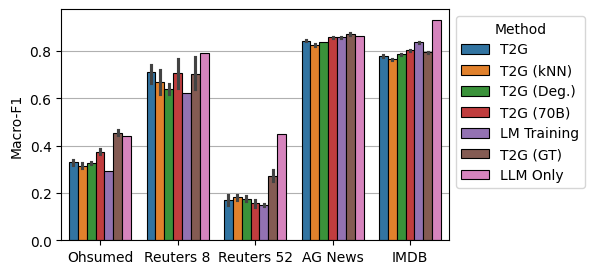

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_performance_barplot(df):
    df = df.replace(datasets_rename)
    df = df.replace(methods_rename)

    hue_order = [methods_rename[method] for method in methods if methods_rename[method] in df['method'].unique()]

    fig,ax = plt.subplots(figsize=(5,3))
    ax = sns.barplot(data=df[df['type'] == 'macro avg'], y='f1-score', x='dataset', hue='method', hue_order=hue_order,
                    edgecolor='black', linewidth=0.8, ax=ax)
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.get_legend().set_title('Method')
    ax.set_xlabel('')
    ax.set_ylabel('Macro-F1')

    ax.grid(axis='y')
    ax.set_axisbelow(True)

    return ax.figure

fig = plot_performance_barplot(results_df[results_df['method'].isin(methods[:-8])])
fig.savefig('figures/overall.pdf', bbox_inches='tight')

In [ ]:
data = results_df[
    (results_df['f1-score'] == 0) &
    (results_df['method'] == 'random') &
    ~(results_df['type']).isin(['accuracy', 'macro avg', 'weighted avg'])].groupby('dataset')['type'].value_counts().reset_index()

data = data.rename({'count': 'missing'}, axis=1).groupby('dataset')['missing'].value_counts().reset_index(allow_duplicates=True).sort_values(['dataset', 'missing'], ascending=False)
data = data.replace(datasets_rename).rename(columns={'dataset': 'Dataset', 'missing': '\# times missing', 'count': '\# classes'})
data.to_latex('tables/table.tex', index=False, multirow=True)
data

<>:7: SyntaxWarning: invalid escape sequence '\#'
<>:7: SyntaxWarning: invalid escape sequence '\#'
<>:7: SyntaxWarning: invalid escape sequence '\#'
<>:7: SyntaxWarning: invalid escape sequence '\#'
/tmp/ipykernel_763269/2926282231.py:7: SyntaxWarning: invalid escape sequence '\#'
  data = data.replace(datasets_rename).rename(columns={'dataset': 'Dataset', 'missing': '\# times missing', 'count': '\# classes'})
/tmp/ipykernel_763269/2926282231.py:7: SyntaxWarning: invalid escape sequence '\#'
  data = data.replace(datasets_rename).rename(columns={'dataset': 'Dataset', 'missing': '\# times missing', 'count': '\# classes'})


,Dataset,\# times missing,\# classes
1,Reuters 52,5,29
2,Reuters 52,1,1
0,Ohsumed,5,1


### Total energy consumed by methods

/tmp/ipykernel_763269/1728488487.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{dataset} ({num})' for dataset,num in num_nodes.items()])


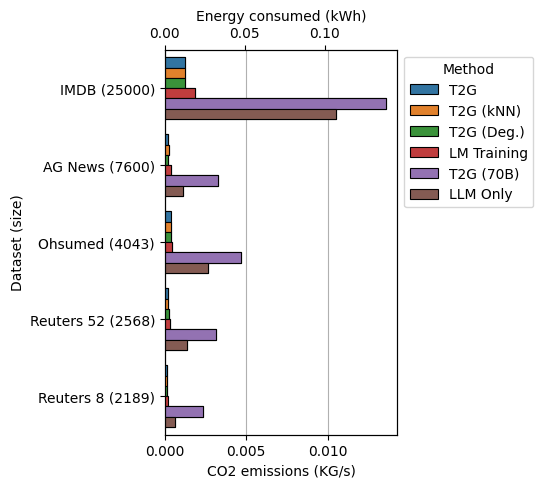

In [ ]:
import matplotlib.pyplot as plt

def plot_resource_use(df):
    df = df.replace(datasets_rename)
    df = df.replace(methods_rename)

    hue_order = [method for method in methods_rename.values() if method in df['method'].unique()]

    num_nodes = df[['dataset', 'num_nodes']].drop_duplicates().set_index('dataset')['num_nodes'].to_dict()
    num_nodes = {k: v for k, v in sorted(num_nodes.items(), key=lambda item: -item[1])}
    order = num_nodes.keys()

    fig,ax = plt.subplots(figsize=(3,5))

    ax = sns.barplot(data=df, x='emissions', y='dataset', hue='method', order=order, hue_order=hue_order, 
                    edgecolor='black', linewidth=0.8, ax=ax, errorbar=None)
    
    ax1 = sns.barplot(data=df, x='energy_consumed', y='dataset', hue='method', order=order, hue_order=hue_order, 
                    edgecolor='black', linewidth=0.8, ax=ax.twiny(), errorbar=None)
    
    ax.set_yticklabels([f'{dataset} ({num})' for dataset,num in num_nodes.items()])
    ax.set_xlabel('CO2 emissions (KG/s)')
    ax.set_ylabel(f'Dataset (size)')
    ax.get_legend().set_title('Method')
    ax.grid(axis='x')
    ax.set_axisbelow(True)
    
    ax1.get_legend().remove()
    ax1.set_xlabel('Energy consumed (kWh)')

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    return fig

methods_to_consider = ['baseline', 'baseline_knn', 'baseline_degree', 'baseline_llama3.1:70b', 'lm_training', 'llm_only']
fig = plot_resource_use(emissions_df[emissions_df['method'].isin(methods_to_consider)])
fig.savefig('figures/emission_energy.pdf', bbox_inches='tight')

### Increasing amount labelled by LLM

/tmp/ipykernel_763269/3999918354.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_res = df_res.replace(map)
/tmp/ipykernel_763269/3999918354.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_emi = df_emi.replace(map)


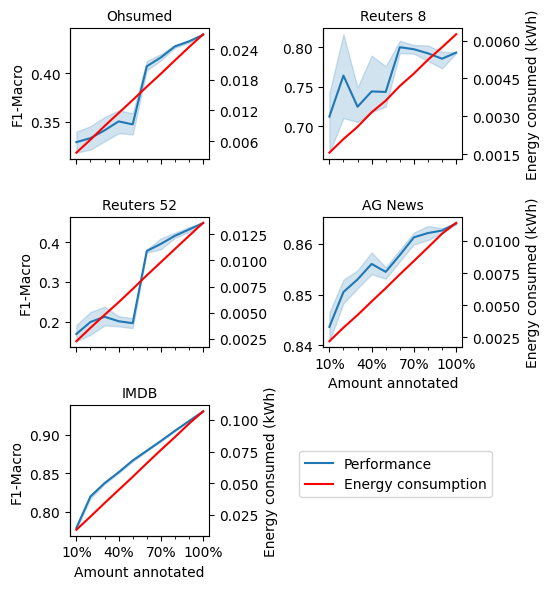

In [ ]:
import seaborn as sns
from matplotlib import ticker

def plot_ablation_lineplots(df_res, df_emi):
    df_res = df_res.replace(datasets_rename)
    df_emi = df_emi.replace(datasets_rename)

    map = {
        'baseline':10,
        'baseline@20':20,
        'baseline@30':30,
        'baseline@40':40,
        'baseline@50':50,
        'baseline@60':60,
        'baseline@70':70,
        'baseline@80':80,
        'baseline@90':90,
        'llm_only': 100
    }

    df_res = df_res.replace(map)
    df_emi = df_emi.replace(map)

    col_wrap = 2

    data = df_res[df_res['type'] == 'macro avg']
    ax1 = sns.relplot(data=data, x='method', y='f1-score', col='dataset', col_order=[datasets_rename[d] for d in datasets], kind='line',
                      col_wrap=col_wrap, aspect=1.4, height=2, facet_kws={'sharey': False})

    ax1.set_titles('{col_name}')
    ax1.set_ylabels('F1-Macro')
    ax1.set_xlabels('Amount annotated')

    for i, (dataset, ax) in enumerate(ax1.axes_dict.items()):
        ax2 = ax.twinx()
        ax2.xaxis.set_major_formatter(ticker.PercentFormatter())
        ax2.xaxis.set_major_locator(ticker.MultipleLocator(30, 10))
        ax2.xaxis.set_minor_locator(ticker.MultipleLocator(10))

        ax2.yaxis.set_major_locator(ticker.MaxNLocator(5))

        sns.lineplot(data=df_emi[df_emi['dataset'] == dataset], x='method', y='energy_consumed', ax=ax2, color='red', errorbar=None)

        if (i+1) % col_wrap and i < len(data['dataset'].unique())-1:
            ax2.set_ylabel('')
        else:
            ax2.set_ylabel('Energy consumed (kWh)')
            
    ax1.figure.tight_layout()
    
    ax1.axes[0].plot([], [], color='tab:blue', label='Performance')
    ax1.axes[0].plot([], [], color='red', label='Energy consumption')
    ax1.figure.legend(loc='lower right', bbox_to_anchor=(0.9, 0.15))

    return ax1.figure

fig = plot_ablation_lineplots(results_df[results_df['method'].isin(methods[-9:] + ['baseline'])].sort_values('method'), 
                        emissions_df[emissions_df['method'].isin(methods[-9:] + ['baseline'])].sort_values('method'))

fig.savefig('figures/ablation.pdf')

### Performance / Energy ratio

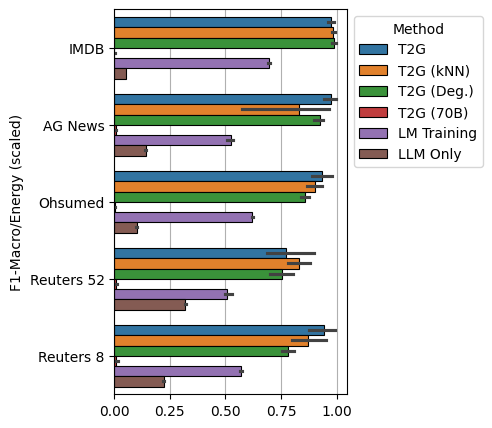

In [ ]:
import matplotlib.pyplot as plt

def plot_scaled_energy_performance_ratio(df_res, df_emi):
    df_res = df_res.replace(datasets_rename)
    df_res = df_res.replace(methods_rename)
    df_emi = df_emi.replace(datasets_rename)
    df_emi = df_emi.replace(methods_rename)

    num_nodes = df_res[['dataset', 'num_nodes']].drop_duplicates().set_index('dataset')['num_nodes'].to_dict()
    num_nodes = {k: v for k, v in sorted(num_nodes.items(), key=lambda item: -item[1])}
    order = num_nodes.keys()

    fig,ax = plt.subplots(figsize=(3,5))

    energy = df_emi.set_index(['dataset', 'method', 'round'])['energy_consumed']
    performance = df_res[df_res['type'] == 'macro avg'].set_index(['dataset', 'method', 'round'])['f1-score']
    data = (performance / energy).rename('ratio').reset_index()
    
    data = data.assign(scaled=data.groupby('dataset')['ratio'].transform(lambda x: (x - x.min()) / (x.max()- x.min())))

    g = sns.barplot(data=data, x='scaled', order=order, y='dataset', hue='method', ax=ax, edgecolor='black', linewidth=0.8)

    ax.set_xlabel('')
    ax.set_ylabel('F1-Macro/Energy (scaled)')
    ax.get_legend().set_title('Method')
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    ax.grid(axis='x')
    ax.set_axisbelow(True)

    return fig

fig = plot_scaled_energy_performance_ratio(results_df[results_df['method'].isin(methods[:5] + methods[6:7])], 
                                     emissions_df[emissions_df['method'].isin(methods[:5] + methods[6:7])])
fig.savefig('figures/performance_energy_ratio.pdf', bbox_inches='tight')